In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "MI"
station_dv = "moisture_index"
station_path = "data/station_inputs/moisture_index_for_maps.csv"
input_model_path = (
    "data/model_inputs/moisture_index_CanRCM4-LE_ens15_1951-2016_ensmean.nc"
)
medians = {"value": 0.9, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = True


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,moisture_index,rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,558,1009,0.880795,-4.286849,10.373390,42.2756,-82.9556,189.6,WINDSOR A,ON,1.957862,0.635876
1,580,1035,0.923519,-3.290372,11.534368,43.0331,-81.1511,278.0,LONDON COMPOSITE,ON,1.600199,0.815739
2,600,1057,0.788974,-2.427524,12.480315,43.6772,-79.6306,173.4,TORONTO LESTER B. PEARSON INT'L A,ON,1.485784,0.750562


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

0.930198193

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/141 [00:00<?, ?it/s]

  1%|▏         | 2/141 [00:01<01:10,  1.97it/s]

  2%|▏         | 3/141 [00:01<01:24,  1.63it/s]

  3%|▎         | 4/141 [00:02<01:35,  1.44it/s]

  4%|▎         | 5/141 [00:03<01:41,  1.34it/s]

  4%|▍         | 6/141 [00:04<01:45,  1.28it/s]

  5%|▍         | 7/141 [00:05<01:54,  1.17it/s]

  6%|▌         | 8/141 [00:06<01:49,  1.21it/s]

  6%|▋         | 9/141 [00:07<01:58,  1.11it/s]

  7%|▋         | 10/141 [00:08<02:05,  1.05it/s]

  8%|▊         | 11/141 [00:09<01:54,  1.13it/s]

  9%|▊         | 12/141 [00:10<01:56,  1.11it/s]

  9%|▉         | 13/141 [00:11<01:56,  1.10it/s]

 10%|▉         | 14/141 [00:11<01:46,  1.19it/s]

 11%|█         | 15/141 [00:12<01:38,  1.29it/s]

 11%|█▏        | 16/141 [00:12<01:31,  1.37it/s]

 12%|█▏        | 17/141 [00:13<01:26,  1.44it/s]

 13%|█▎        | 18/141 [00:14<01:22,  1.50it/s]

 13%|█▎        | 19/141 [00:14<01:22,  1.48it/s]

 14%|█▍        | 20/141 [00:15<01:20,  1.51it/s]

 15%|█▍        | 21/141 [00:16<01:34,  1.27it/s]

 16%|█▌        | 22/141 [00:17<01:36,  1.24it/s]

 16%|█▋        | 23/141 [00:18<01:31,  1.28it/s]

 17%|█▋        | 24/141 [00:18<01:24,  1.39it/s]

 18%|█▊        | 25/141 [00:19<01:34,  1.22it/s]

 18%|█▊        | 26/141 [00:20<01:26,  1.33it/s]

 19%|█▉        | 27/141 [00:21<01:31,  1.25it/s]

 20%|█▉        | 28/141 [00:21<01:24,  1.34it/s]

 21%|██        | 29/141 [00:22<01:22,  1.36it/s]

 21%|██▏       | 30/141 [00:23<01:25,  1.30it/s]

 22%|██▏       | 31/141 [00:24<01:18,  1.39it/s]

 23%|██▎       | 32/141 [00:24<01:18,  1.39it/s]

 23%|██▎       | 33/141 [00:25<01:18,  1.38it/s]

 24%|██▍       | 34/141 [00:26<01:14,  1.44it/s]

 25%|██▍       | 35/141 [00:26<01:17,  1.36it/s]

 26%|██▌       | 36/141 [00:27<01:15,  1.39it/s]

 26%|██▌       | 37/141 [00:28<01:30,  1.14it/s]

 27%|██▋       | 38/141 [00:29<01:34,  1.09it/s]

 28%|██▊       | 39/141 [00:30<01:37,  1.05it/s]

 28%|██▊       | 40/141 [00:31<01:29,  1.13it/s]

 29%|██▉       | 41/141 [00:32<01:20,  1.24it/s]

 30%|██▉       | 42/141 [00:32<01:13,  1.34it/s]

 30%|███       | 43/141 [00:33<01:08,  1.42it/s]

 31%|███       | 44/141 [00:34<01:04,  1.51it/s]

 32%|███▏      | 45/141 [00:34<01:00,  1.58it/s]

 33%|███▎      | 46/141 [00:35<00:58,  1.62it/s]

 33%|███▎      | 47/141 [00:35<00:56,  1.66it/s]

 34%|███▍      | 48/141 [00:36<00:55,  1.67it/s]

 35%|███▍      | 49/141 [00:37<00:56,  1.62it/s]

 35%|███▌      | 50/141 [00:37<00:59,  1.54it/s]

 36%|███▌      | 51/141 [00:38<01:01,  1.46it/s]

 37%|███▋      | 52/141 [00:39<01:02,  1.42it/s]

 38%|███▊      | 53/141 [00:39<01:01,  1.44it/s]

 38%|███▊      | 54/141 [00:40<01:02,  1.39it/s]

 39%|███▉      | 55/141 [00:41<00:59,  1.45it/s]

 40%|███▉      | 56/141 [00:42<00:58,  1.45it/s]

 40%|████      | 57/141 [00:42<00:56,  1.49it/s]

 41%|████      | 58/141 [00:43<00:55,  1.50it/s]

 42%|████▏     | 59/141 [00:43<00:54,  1.50it/s]

 43%|████▎     | 60/141 [00:44<00:53,  1.51it/s]

 43%|████▎     | 61/141 [00:45<00:51,  1.56it/s]

 44%|████▍     | 62/141 [00:45<00:49,  1.58it/s]

 45%|████▍     | 63/141 [00:46<00:49,  1.58it/s]

 45%|████▌     | 64/141 [00:47<00:50,  1.52it/s]

 46%|████▌     | 65/141 [00:47<00:52,  1.45it/s]

 47%|████▋     | 66/141 [00:48<00:52,  1.44it/s]

 48%|████▊     | 67/141 [00:49<00:49,  1.49it/s]

 48%|████▊     | 68/141 [00:49<00:46,  1.56it/s]

 49%|████▉     | 69/141 [00:50<00:44,  1.63it/s]

 50%|████▉     | 70/141 [00:51<00:45,  1.57it/s]

 50%|█████     | 71/141 [00:51<00:44,  1.57it/s]

 51%|█████     | 72/141 [00:52<00:42,  1.63it/s]

 52%|█████▏    | 73/141 [00:52<00:41,  1.66it/s]

 52%|█████▏    | 74/141 [00:53<00:41,  1.63it/s]

 53%|█████▎    | 75/141 [00:54<00:39,  1.68it/s]

 54%|█████▍    | 76/141 [00:54<00:38,  1.68it/s]

 55%|█████▍    | 77/141 [00:55<00:37,  1.69it/s]

 55%|█████▌    | 78/141 [00:56<00:42,  1.49it/s]

 56%|█████▌    | 79/141 [00:57<00:50,  1.22it/s]

 57%|█████▋    | 80/141 [00:57<00:45,  1.35it/s]

 57%|█████▋    | 81/141 [00:58<00:45,  1.30it/s]

 58%|█████▊    | 82/141 [00:59<00:41,  1.41it/s]

 59%|█████▉    | 83/141 [01:00<00:43,  1.35it/s]

 60%|█████▉    | 84/141 [01:01<00:49,  1.14it/s]

 60%|██████    | 85/141 [01:01<00:44,  1.26it/s]

 61%|██████    | 86/141 [01:02<00:42,  1.30it/s]

 62%|██████▏   | 87/141 [01:03<00:43,  1.25it/s]

 62%|██████▏   | 88/141 [01:04<00:40,  1.30it/s]

 63%|██████▎   | 89/141 [01:04<00:37,  1.39it/s]

 64%|██████▍   | 90/141 [01:05<00:35,  1.45it/s]

 65%|██████▍   | 91/141 [01:05<00:33,  1.49it/s]

 65%|██████▌   | 92/141 [01:06<00:32,  1.53it/s]

 66%|██████▌   | 93/141 [01:07<00:31,  1.54it/s]

 67%|██████▋   | 94/141 [01:07<00:30,  1.55it/s]

 67%|██████▋   | 95/141 [01:08<00:34,  1.32it/s]

 68%|██████▊   | 96/141 [01:09<00:32,  1.38it/s]

 69%|██████▉   | 97/141 [01:10<00:31,  1.40it/s]

 70%|██████▉   | 98/141 [01:11<00:32,  1.34it/s]

 70%|███████   | 99/141 [01:11<00:31,  1.34it/s]

 71%|███████   | 100/141 [01:12<00:30,  1.33it/s]

 72%|███████▏  | 101/141 [01:13<00:31,  1.27it/s]

 72%|███████▏  | 102/141 [01:14<00:33,  1.15it/s]

 73%|███████▎  | 103/141 [01:15<00:31,  1.20it/s]

 74%|███████▍  | 104/141 [01:15<00:29,  1.24it/s]

 74%|███████▍  | 105/141 [01:17<00:32,  1.10it/s]

 75%|███████▌  | 106/141 [01:17<00:31,  1.12it/s]

 76%|███████▌  | 107/141 [01:18<00:29,  1.17it/s]

 77%|███████▋  | 108/141 [01:19<00:27,  1.21it/s]

 77%|███████▋  | 109/141 [01:20<00:31,  1.01it/s]

 78%|███████▊  | 110/141 [01:21<00:28,  1.08it/s]

 79%|███████▊  | 111/141 [01:22<00:27,  1.08it/s]

 79%|███████▉  | 112/141 [01:23<00:25,  1.14it/s]

 80%|████████  | 113/141 [01:24<00:24,  1.16it/s]

 81%|████████  | 114/141 [01:24<00:22,  1.18it/s]

 82%|████████▏ | 115/141 [01:25<00:21,  1.22it/s]

 82%|████████▏ | 116/141 [01:26<00:20,  1.23it/s]

 83%|████████▎ | 117/141 [01:27<00:20,  1.18it/s]

 84%|████████▎ | 118/141 [01:28<00:21,  1.08it/s]

 84%|████████▍ | 119/141 [01:29<00:19,  1.13it/s]

 85%|████████▌ | 120/141 [01:30<00:19,  1.07it/s]

 86%|████████▌ | 121/141 [01:31<00:21,  1.07s/it]

 87%|████████▋ | 122/141 [01:32<00:19,  1.04s/it]

 87%|████████▋ | 123/141 [01:33<00:19,  1.07s/it]

 88%|████████▊ | 124/141 [01:35<00:20,  1.20s/it]

 89%|████████▊ | 125/141 [01:36<00:19,  1.23s/it]

 89%|████████▉ | 126/141 [01:37<00:16,  1.11s/it]

 90%|█████████ | 127/141 [01:38<00:15,  1.14s/it]

 91%|█████████ | 128/141 [01:40<00:18,  1.44s/it]

 91%|█████████▏| 129/141 [01:41<00:14,  1.25s/it]

 92%|█████████▏| 130/141 [01:43<00:14,  1.30s/it]

 93%|█████████▎| 131/141 [01:44<00:12,  1.29s/it]

 94%|█████████▎| 132/141 [01:46<00:13,  1.50s/it]

 94%|█████████▍| 133/141 [01:48<00:13,  1.69s/it]

 95%|█████████▌| 134/141 [01:49<00:10,  1.45s/it]

 96%|█████████▌| 135/141 [01:51<00:09,  1.63s/it]

 96%|█████████▋| 136/141 [01:53<00:08,  1.72s/it]

 97%|█████████▋| 137/141 [01:55<00:07,  1.78s/it]

 98%|█████████▊| 138/141 [01:58<00:06,  2.14s/it]

 99%|█████████▊| 139/141 [02:00<00:04,  2.12s/it]

 99%|█████████▉| 140/141 [02:02<00:02,  2.13s/it]

100%|██████████| 141/141 [02:04<00:00,  2.12s/it]

100%|██████████| 141/141 [02:07<00:00,  1.11it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'MI Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

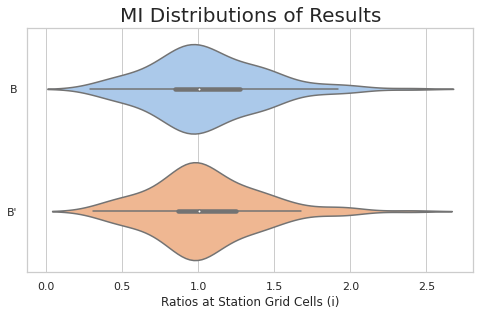

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 0.9750680037554351 
UAA_station_mean 0.930198193 
Combined 0.9526330983777176


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: unitless


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


f: 0.9704719136961971


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)